In [220]:
config_file = 'delineation/configs/dislocation_segmentation.yml'
aug_config_file = 'delineation/configs/aug.yml'
import torch
from skimage.morphology import medial_axis, skeletonize, thin

from delineation.configs.defaults_segmentation import _C as cfg
from delineation.datasets import make_data_loader
from delineation.models import build_segmentation_model
from delineation.utils import settings, cost_volume_helpers
from delineation.utils.settings import evaluate_results

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import yaml

cfg.merge_from_file(config_file)
with open(aug_config_file, 'r') as ymlfile:
    cfg_aug = yaml.load(aug_config_file)

_device = settings.initialize_cuda_and_logging(cfg)  # '_device' is GLOBAL VAR

train_loader, val_loader = make_data_loader(cfg, cfg_aug)
seg_model = build_segmentation_model(cfg)


Using cuda
unet-efficientnet


/home/dagnyt/anaconda3/envs/fast/lib/python3.7/site-packages/ipykernel_launcher.py:24: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [221]:
seg_model.load_state_dict(torch.load('/home/dagnyt/EPFL/dislocations/logs/dislocations_segmentation_effnet-b0/130_segmentor.tar')['state_dict'])
seg_model.eval()


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

In [222]:
import cv2
from extract_patches.core import extract_patches
import os 
print(os.listdir('/home/dagnyt/EPFL/dislocations/ALL_DATA_fixed_bottom_img_with_semantics_resized/test/left_image/'))
# imgL = cv2.imread('/media/dagnyt/E46EF6F16EF6BB7E/Projects/EPFL/ALL_DATA_fixed_bottom_img_with_semantics/2019-12-02_TiAl_box3n15_zoom_7_5/Aligned_9_of_90005.png', 0)
# imgR = cv2.imread('/media/dagnyt/E46EF6F16EF6BB7E/Projects/EPFL/ALL_DATA_fixed_bottom_img_with_semantics/2019-12-02_TiAl_box3n15_zoom_7_5/Aligned_9_of_90007.png', 0)

# imgL = cv2.imread('/home/dagnyt/EPFL/dislocations/ALL_DATA_fixed_bottom_img_with_semantics_resized/val/left_image/2019-12-02_TiAl_box3n15_zoom_4_3_Aligned_9_of_90003_LEFT.png')
# imgR = cv2.imread('/home/dagnyt/EPFL/dislocations/ALL_DATA_fixed_bottom_img_with_semantics_resized/val/right_image/2019-12-02_TiAl_box3n15_zoom_4_3_Aligned_9_of_90003_RIGHT.png')

imgL = cv2.imread('/home/dagnyt/EPFL/dislocations/ALL_DATA_fixed_bottom_img_with_semantics_resized/test/left_image/New_dataset_01_05_2020_pair_10_11_10010_LEFT.png')
imgR = cv2.imread('/home/dagnyt/EPFL/dislocations/ALL_DATA_fixed_bottom_img_with_semantics_resized/test/right_image/New_dataset_01_05_2020_pair_10_11_10010_RIGHT.png')

# imgL = cv2.imread('/home/dagnyt/EPFL/dislocations/ALL_DATA_fixed_bottom_img_with_semantics_resized/test/left_image/New_dataset_01_05_2020_pair_8_10_10010_LEFT.png')
# imgR = cv2.imread('/home/dagnyt/EPFL/dislocations/ALL_DATA_fixed_bottom_img_with_semantics_resized/test/right_image/New_dataset_01_05_2020_pair_8_10_10010_RIGHT.png')

imgL = cv2.resize(imgL, (1024,1024))
imgR = cv2.resize(imgR, (1024,1024))



['New_dataset_01_05_2020_pair_0_1_10000_LEFT.png', 'New_dataset_01_05_2020_pair_17_18_10017_LEFT.png', 'New_dataset_01_05_2020_pair_8_10_10010_LEFT.png', 'New_dataset_01_05_2020_pair_8_9_10008_LEFT.png', 'New_dataset_01_05_2020_pair_16_17_10016_LEFT.png', 'New_dataset_01_05_2020_pair_10_11_10010_LEFT.png', 'New_dataset_01_05_2020_pair_14_15_10014_LEFT.png', 'New_dataset_01_05_2020_pair_8_13_10008_LEFT.png', 'New_dataset_01_05_2020_pair_4_5_10004_LEFT.png', 'New_dataset_01_05_2020_pair_12_13_10012_LEFT.png', 'New_dataset_01_05_2020_pair_6_7_10006_LEFT.png', 'New_dataset_01_05_2020_pair_2_3_10002_LEFT.png', 'New_dataset_01_05_2020_pair_8_12_10012_LEFT.png', 'New_dataset_01_05_2020_pair_8_11_10011_LEFT.png']


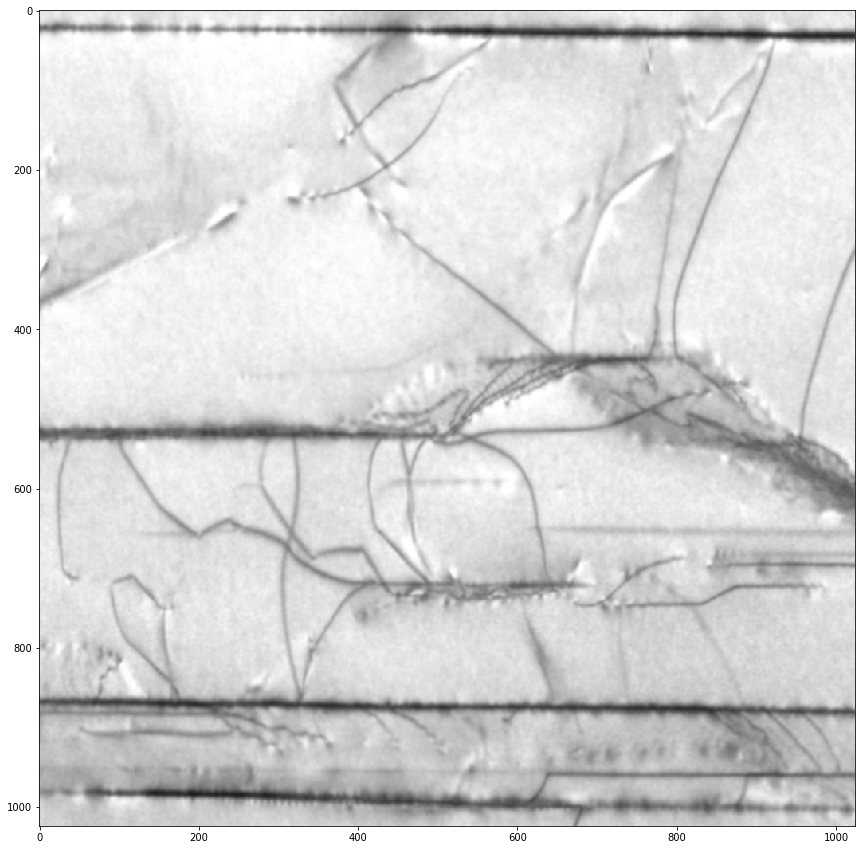

In [224]:
with torch.no_grad():
    torch.cuda.empty_cache()

    seg_res1 = seg_model(torch.from_numpy(imgL/255.0).permute(2,0,1).unsqueeze(0).cuda().float())
    seg_res2 = seg_model(torch.from_numpy(imgR/255.0).permute(2,0,1).unsqueeze(0).cuda().float())

    seg_map1 = seg_res1[0].squeeze().data.cpu().numpy()>0.05
    seg_map2 = seg_res2[0].squeeze().data.cpu().numpy()>0.05

plt.figure(figsize = (15,15))
plt.imshow(imgL, cmap='gray')

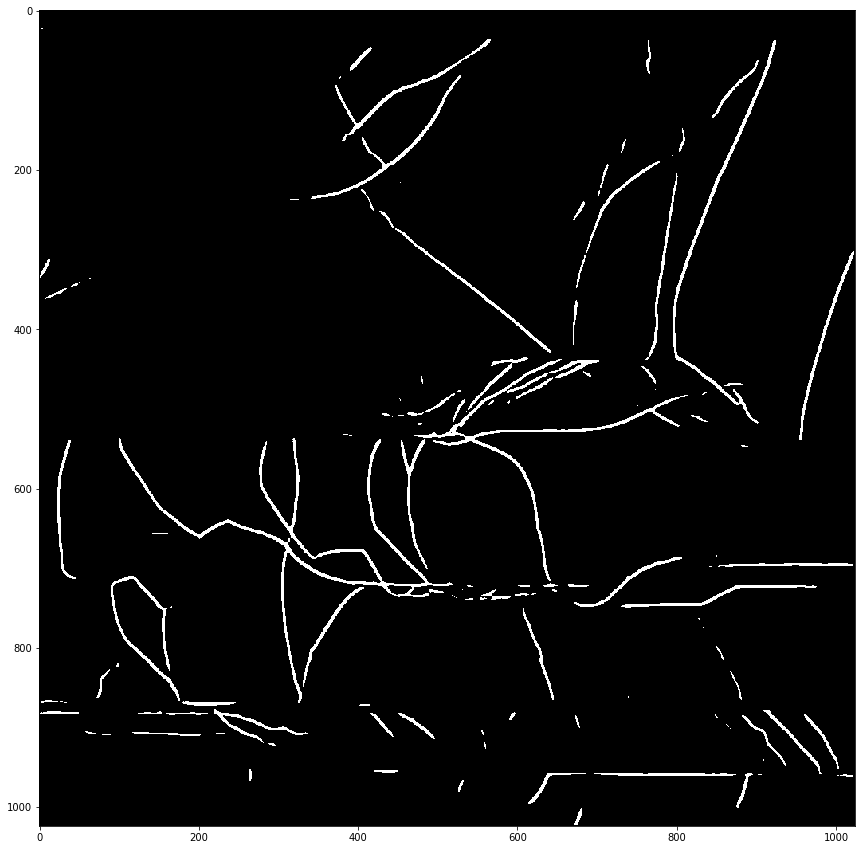

In [225]:
plt.figure(figsize = (15,15))
plt.imshow(seg_map1, cmap='gray')


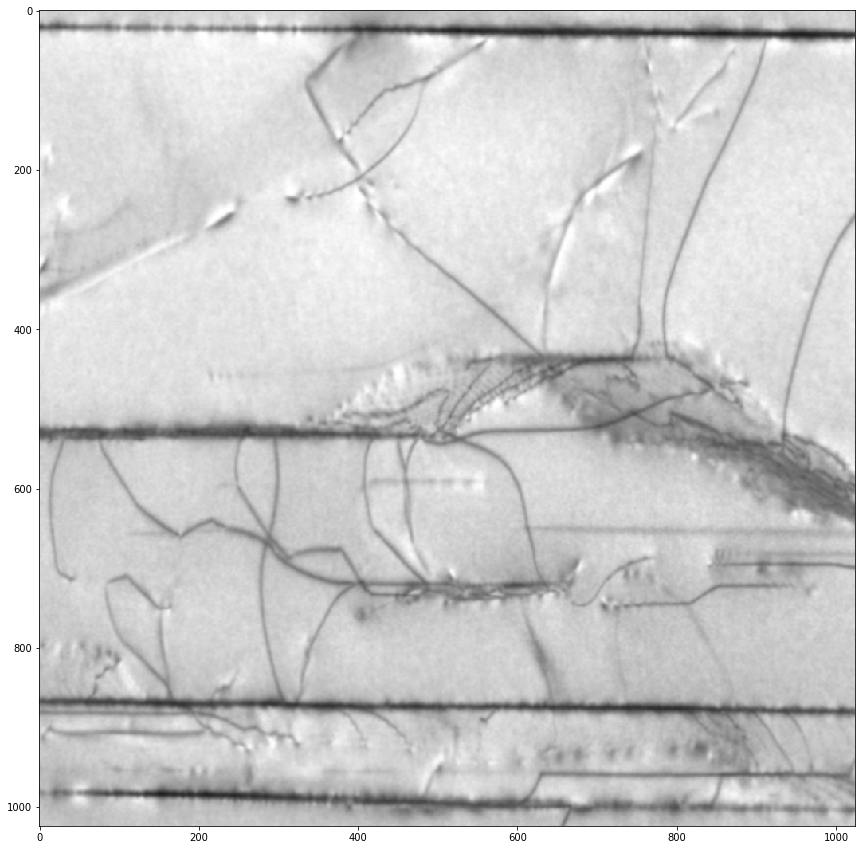

In [226]:
plt.figure(figsize = (15,15))
plt.imshow(imgR, cmap='gray')

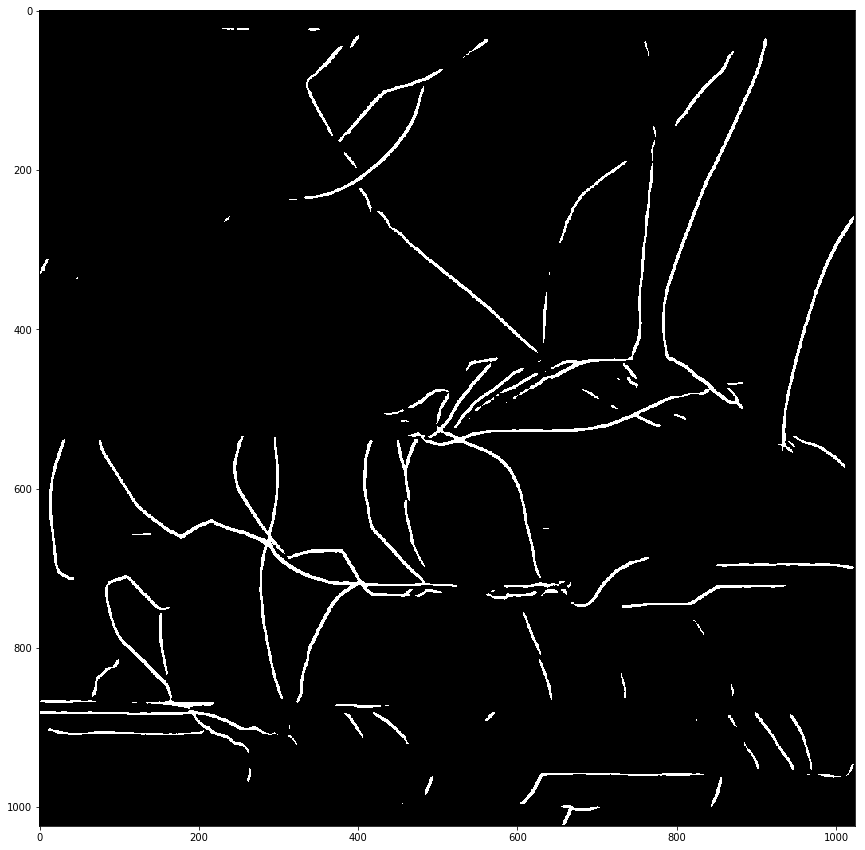

In [227]:
plt.figure(figsize = (15,15))
plt.imshow(seg_map2, cmap='gray')

In [228]:
kpts1 = np.where(seg_map1 == 1)
kpts1 = [[kpts1[0][idx], kpts1[1][idx]] for idx in range(len(kpts1[0]))]
kpts2 = np.where(seg_map2 == 1)
kpts2 = [[kpts2[0][idx], kpts2[1][idx]] for idx in range(len(kpts2[0]))]

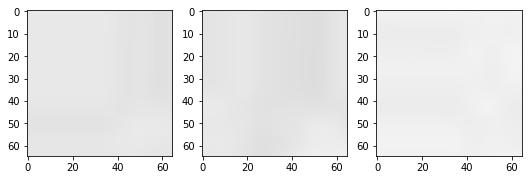

In [229]:
PATCH_SIZE = 65
mrSize = 16.0
kpCheck = [cv2.KeyPoint(0.0, 0.0, 1), cv2.KeyPoint(0.0, 0.0, 1), cv2.KeyPoint(100.0, 0.0, 1), cv2.KeyPoint(0.0, 100.0, 1)]
patches = extract_patches(kpCheck, imgL, PATCH_SIZE, mrSize, 'cv2')
show_idx = 0
fig = plt.figure(figsize=(12, 20))
for i in range(1,4):
    fig.add_subplot(1, 4, i) 
    plt.imshow(patches[show_idx+i], cmap='gray', vmin=0, vmax=255)

In [230]:
PATCH_SIZE = 65
mrSize = 16.0
kpL = [cv2.KeyPoint(kp[1], kp[0], 1) for kp in kpts1]
kpR = [cv2.KeyPoint(kp[1], kp[0], 1) for kp in kpts2]

try:
    imgL, imgR = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY), cv2.cvtColor(imgR, cv2.COLOR_RGB2GRAY)
except Exception as ex:
    print(ex)
    
patches1 = extract_patches(kpL, imgL, PATCH_SIZE, mrSize, 'cv2')
patches2 = extract_patches(kpR, imgR, PATCH_SIZE, mrSize, 'cv2')

print(len(patches1))
print(len(patches2))
kpL[0].pt

30385
32155


(3.0, 22.0)

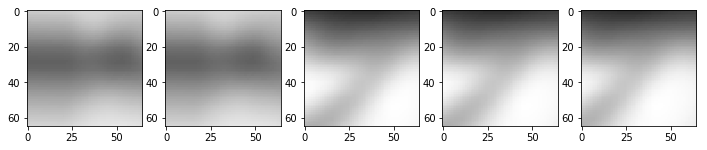

In [231]:
show_idx = 0
fig = plt.figure(figsize=(12, 20))
for i in range(1,6):
    fig.add_subplot(1, 5, i) 
    plt.imshow(patches1[show_idx+i], cmap='gray', vmin=0, vmax=255)

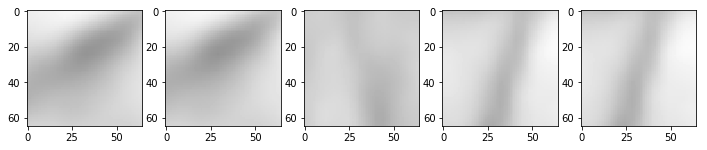

In [232]:
show_idx = 300
fig = plt.figure(figsize=(12, 20))
for i in range(1,6):
    fig.add_subplot(1, 5, i) 
    plt.imshow(patches2[show_idx+i], cmap='gray', vmin=0, vmax=255)


In [233]:
try:
    del seg_model
except Exception:
    print()

import kornia
hardnet = kornia.feature.HardNet().cuda()
hardnet.eval()

HardNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): R

In [234]:
torch.cuda.empty_cache()
import torch
bs = 1024
desL, desR = [], []

with torch.no_grad():
    patches1 = np.array([cv2.resize(patch,(32,32)) / 255. for patch in patches1])
    patches1 -= 0.443728476019
    patches1 /= 0.20197947209
    
    for i in range(0, len(patches1), bs):
        data_a = patches1[i: i + bs, :, :].astype(np.float32)
        desc1 = hardnet(torch.from_numpy(data_a).cuda().unsqueeze(1).float())
        desL.extend(desc1.data.cpu().numpy().squeeze())
        
with torch.no_grad():
    patches2 = np.array([cv2.resize(patch,(32,32)) / 255. for patch in patches2])
    patches2 -= 0.443728476019
    patches2 /= 0.20197947209
    
    for i in range(0, len(patches2), bs):
        data_a = patches2[i: i + bs, :, :].astype(np.float32)
        desc2 = hardnet(torch.from_numpy(data_a).cuda().unsqueeze(1).float())
        desR.extend(desc2.data.cpu().numpy().squeeze())
        
desL, desR = np.array(desL), np.array(desR)
print(len(desL))
print(len(desR))


30385
32155


In [235]:
kpts1_same_y = {}
kpts2_same_y = {}

for idx, kpt in enumerate(kpL):
    if kpt.pt[1] in kpts1_same_y:
        kpts1_same_y[kpt.pt[1]].append((kpt, desL[idx], idx))
    else:
        kpts1_same_y[kpt.pt[1]] = [(kpt, desL[idx], idx)]

for idx, kpt in enumerate(kpR):
    if kpt.pt[1] in kpts2_same_y:
        kpts2_same_y[kpt.pt[1]].append((kpt, desR[idx], idx))
    else:
        kpts2_same_y[kpt.pt[1]] = [(kpt, desR[idx], idx)]
        
keys = kpts1_same_y.keys()

from scipy.optimize import linear_sum_assignment
from scipy import spatial

matches, matches_r = [], []

for key in keys:
    try:
        im1_kp = kpts1_same_y[key]
        im2_kp = kpts2_same_y[key]

        descs1 = np.array([x[1] for x in im1_kp])
        descs2 = np.array([x[1] for x in im2_kp])

        indx1 = np.array([x[2] for x in im1_kp])
        indx2 = np.array([x[2] for x in im2_kp])
        
        cost = spatial.distance.cdist(descs1, descs2, metric='euclidean')

        row_ind, col_ind = linear_sum_assignment(cost)

        indx1, indx2 = indx1[row_ind], indx2[col_ind]

        matches.extend([cv2.DMatch(indx1[i], indx2[i], 0) for i in range(len(indx1))])

    except Exception as ex:
        print(ex)
   # break

good = matches
good_r = matches_r

# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks = 50)
# flann = cv2.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(desL,desR,k=2)
# print(matches[0][0].trainIdx, matches[0][1].trainIdx)
# good = []
# for m,n in matches:
#     if m.distance < 0.99*n.distance:
#         good.append(m)
print(len(good))
print(len(good_r))

22.0
28255
0


<module 'torch.nn.functional' from '/home/dagnyt/anaconda3/envs/fast/lib/python3.7/site-packages/torch/nn/functional.py'>
6203


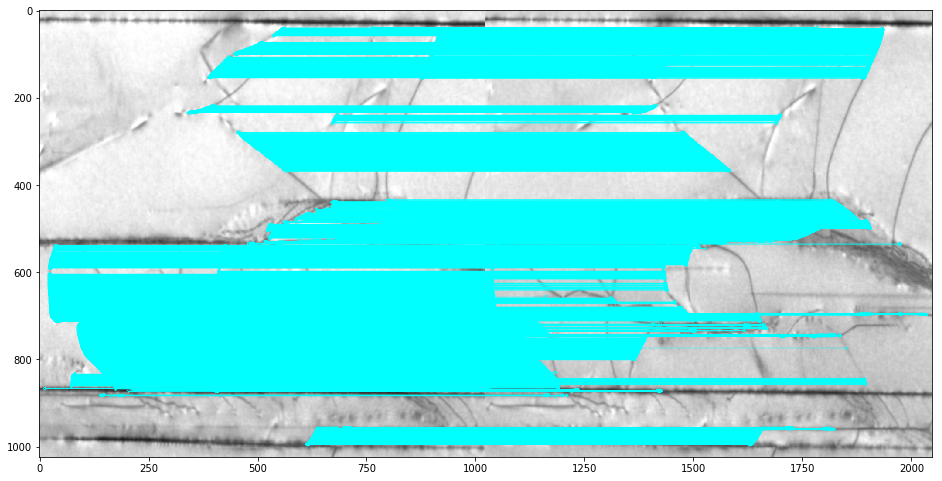

(<matplotlib.image.AxesImage at 0x7fe16fa153d0>, None)

In [236]:
MIN_MATCH_COUNT = 8
import pyransac

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kpL[m.queryIdx].pt for m in good ]).reshape(-1,1,2).squeeze()
    dst_pts = np.float32([ kpR[m.trainIdx].pt for m in good ]).reshape(-1,1,2).squeeze()
    #F, mask_r = pyransac.findHomography(src_pts_r, dst_pts_r, 15.0)

    M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)
    matchesMask = mask.ravel().tolist()
    
print(F)
print(len(np.where(np.array(matchesMask)==1)[0]))
draw_params = dict(matchColor = (0,255,255), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
match_img = cv2.drawMatches(imgL,kpL,imgR,kpR,good,None,**draw_params)

fig = plt.figure(figsize=(16, 16))
plt.imshow(match_img, 'gray'),plt.show()

[[ 1.72932771e+00  2.33375196e-03 -2.78874708e+01]
 [ 2.64678584e-03  1.73437246e+00 -1.50894053e+00]
 [ 5.10394719e-06  5.12075278e-06  1.72820829e+00]]
23833


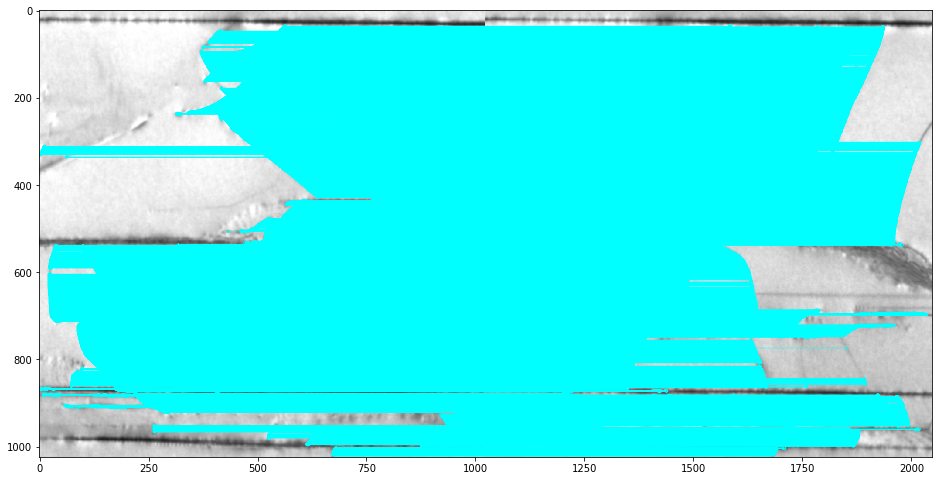

(<matplotlib.image.AxesImage at 0x7fe1c21527d0>, None)

In [237]:
MIN_MATCH_COUNT = 8
import pyransac

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kpL[m.queryIdx].pt for m in good ]).reshape(-1,1,2).squeeze()
    dst_pts = np.float32([ kpR[m.trainIdx].pt for m in good ]).reshape(-1,1,2).squeeze()
    F, mask = pyransac.findHomography(src_pts, dst_pts, 25.0)

 #   M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)
    matchesMask = mask.ravel().tolist()
    
print(F)
print(len(np.where(np.array(matchesMask)==1)[0]))
draw_params = dict(matchColor = (0,255,255), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
match_img = cv2.drawMatches(imgL,kpL,imgR,kpR,good,None,**draw_params)

fig = plt.figure(figsize=(16, 16))
plt.imshow(match_img, 'gray'),plt.show()

In [238]:
differences = dst_pts[mask.squeeze()] - src_pts[mask.squeeze()]
differences = differences.squeeze()
print(differences)

[[ -3.   0.]
 [ -3.   0.]
 [ -3.   0.]
 ...
 [-16.   0.]
 [-16.   0.]
 [-16.   0.]]


20.0


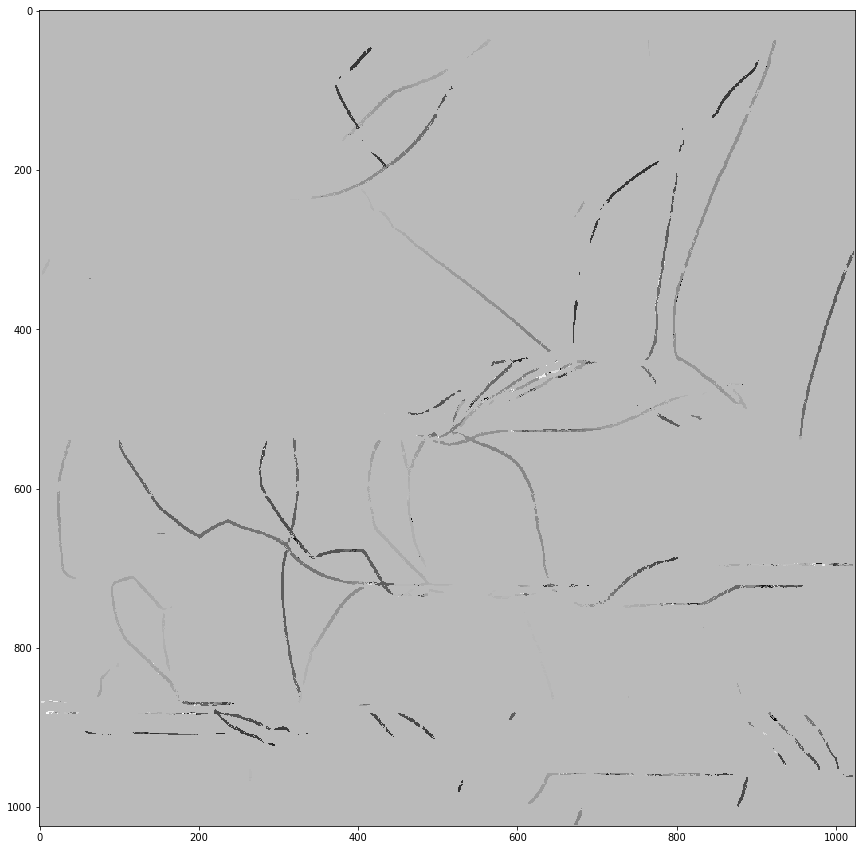

In [239]:
dl = np.zeros(imgL.shape)
seg_masked = np.zeros(imgL.shape)

for idx, kp in enumerate(src_pts[mask.squeeze()]):
    dl[int(kp[1]),int(kp[0])]= int(differences[idx][0])
    seg_masked[int(kp[1]),int(kp[0])] = 1
print(dl.max())
plt.figure(figsize = (15,15))
plt.imshow(dl, cmap='gray')

In [240]:
# import torch.nn.functional as F

# def warp(image, disparity):
#     ''' image : left_image (N, C, H, W)
#         flow  : right disparity
#         output : right image
#         Requires CUDA available GPU'''

#     # normalize flow-field vector
#     H, W = image.size()[2], image.size()[3]
#     disparity = disparity.permute(0,2,3,1)
#     flow = torch.nn.ZeroPad2d((0,1,0,0))(disparity)
#     flow = 2 * flow / W

#     # create normalized meshgrid
#     a = torch.linspace(-1.0, 1.0, H, dtype=torch.float32, requires_grad=False).cuda()
#     b = torch.linspace(-1.0, 1.0, W, dtype=torch.float32, requires_grad=False).cuda()
#     yy = a.view(-1,1).repeat(1, W)
#     xx = b.repeat(H, 1)

#     meshgrid = torch.cat([xx.unsqueeze_(2), yy.unsqueeze_(2)], 2).unsqueeze_(0)

#     # add flow to meshgrid
#     pixloc = meshgrid + flow

#     # sample grid
#     warped_image = F.grid_sample(image, pixloc)
#     return warped_image

# right_warped = warp(torch.from_numpy(seg_masked_r).unsqueeze(0).unsqueeze(0).cuda(), torch.from_numpy(dl).unsqueeze(0).unsqueeze(0).cuda())
# plt.figure(figsize = (15,15))
# plt.imshow(right_warped.squeeze().data.cpu().numpy(), cmap='gray')

In [241]:
from delineation.utils import settings, cost_volume_helpers
seg_map_ = torch.from_numpy(seg_masked).unsqueeze(0).unsqueeze(0).numpy()
dl_ = torch.from_numpy(dl).unsqueeze(0).unsqueeze(0).permute(0, 2, 3, 1).cpu().numpy()
max_disp = int(max(abs(dl_.min()), dl_.max())+5)
print(max_disp)
vol = cost_volume_helpers.back_project_numpy(seg_map_[0,0,:,:], dl_[0,:,:,:], max_disp, mode='two-sided')
print(vol.shape)
print(dl_.min(), dl_.max())



59
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1, 118, 1024, 1024)
-54.0 20.0


In [243]:
for idx, rotation_angle in enumerate(range(-20, 21, 1)):
    cost_volume_helpers.visualize_volume('New_dataset_01_05_2020_pair_10_11_10010', vol[0, :, :, :],
                                                         rotation_angle,
                                                         cfg.LOGGING.LOG_DIR,
                                                         mode='scatter',
                                                         save_ext=str(idx)+'.png',
                                                         plot=False)